Entraînement du Classifieur Génératif (Proxy MP-DBM)...
Epoch 1 | Loss: 0.3532
Epoch 2 | Loss: 0.1384
Epoch 3 | Loss: 0.0920
Epoch 4 | Loss: 0.0713
Epoch 5 | Loss: 0.0541

--- Test de Vulnérabilité (Epsilon=0.25) sur TOUT le test set ---
Error Rate Clean      : 2.48% (Cible Papier: ~0.88%)
Error Rate Adversaire : 99.66% (Cible Papier: ~97.5%)


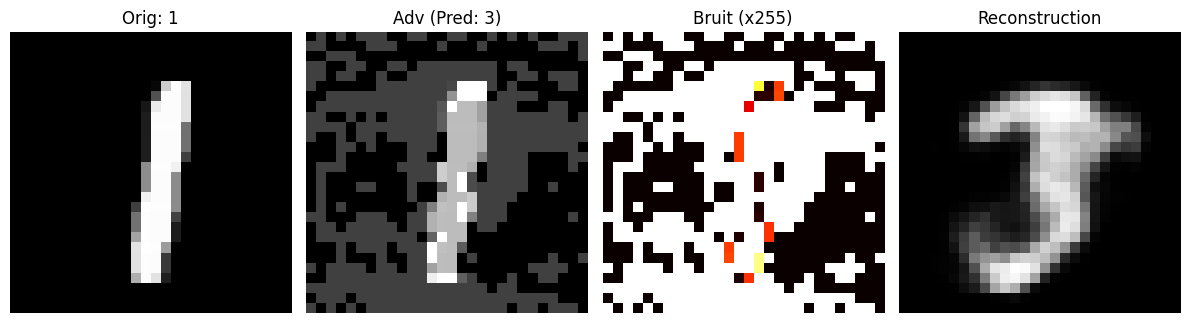

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPSILON = 0.25

# Modèle génératif Proxy (Autoencoder + Classifier)
class GenerativeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Encodeur (Inférence)
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        
        # Décodeur (Génératif)
        self.decoder = nn.Sequential(
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
        
        # Classifieur (Discriminatif)
        self.classifier = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        logits = self.classifier(latent)
        return logits, reconstruction

# Entraînement
train_loader = DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=False
)

model_gen = GenerativeClassifier().to(DEVICE)
optimizer = optim.Adam(model_gen.parameters(), lr=0.001)
GEN_WEIGHT = 1.0 

print("Entraînement du Classifieur Génératif (Proxy MP-DBM)...")
model_gen.train()
for epoch in range(5):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x_flat = x.view(-1, 784)
        
        optimizer.zero_grad()
        logits, x_recon = model_gen(x)
        
        loss_cls = nn.CrossEntropyLoss()(logits, y)
        loss_gen = nn.MSELoss()(x_recon, x_flat)
        loss = loss_cls + GEN_WEIGHT * loss_gen
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

# Test de Vulnérabilité 
print(f"\n Test de Vulnérabilité (Epsilon={EPSILON}) sur le test set ")
model_gen.eval()

correct_clean = 0
correct_adv = 0
total = 0

# Variables pour stocker un exemple pour la visualisation finale
sample_images = None
sample_adv = None
sample_recon = None
sample_labels = None
sample_preds = None

for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    images.requires_grad = True

    logits, _ = model_gen(images)
    loss = nn.CrossEntropyLoss()(logits, labels)
    correct_clean += (logits.argmax(1) == labels).sum().item()

    model_gen.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    adv_images = torch.clamp(images + EPSILON * data_grad.sign(), 0, 1)

    logits_adv, x_recon_adv = model_gen(adv_images)
    correct_adv += (logits_adv.argmax(1) == labels).sum().item()
    
    total += labels.size(0)

    if total >= len(test_loader.dataset) - BATCH_SIZE:
        sample_images = images.detach().cpu()
        sample_adv = adv_images.detach().cpu()
        sample_recon = x_recon_adv.detach().cpu()
        sample_labels = labels.detach().cpu()
        sample_preds = logits_adv.argmax(1).detach().cpu()

error_rate_clean = 100 * (1 - correct_clean / total)
error_rate_adv = 100 * (1 - correct_adv / total)

print(f"Error Rate Clean      : {error_rate_clean:.2f}% (Cible Papier: ~0.88%)")
print(f"Error Rate Adversaire : {error_rate_adv:.2f}% (Cible Papier: ~97.5%)")

# Visualisation 
plt.figure(figsize=(12, 5))
idx = 0

# Original
plt.subplot(1, 4, 1)
plt.title(f"Orig: {sample_labels[idx].item()}")
plt.imshow(sample_images[idx].squeeze(), cmap='gray')
plt.axis('off')

# Adversaire
plt.subplot(1, 4, 2)
plt.title(f"Adv (Pred: {sample_preds[idx].item()})")
plt.imshow(sample_adv[idx].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Bruit (x255)") # Amplifié pour voir
diff = (sample_adv[idx] - sample_images[idx]).abs().squeeze()
plt.imshow(diff, cmap='hot')
plt.axis('off')

# Reconstruction 
plt.subplot(1, 4, 4)
plt.title("Reconstruction")
plt.imshow(sample_recon[idx].view(28, 28), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Dans l'article, une hypothèse est testée : est-ce que l'entraînement génératif peut protéger un modèle ?

Un modèle purement discriminatif (qui cherche une frontière de décision) peut être paresseux et se baser sur des corrélations superficielles. 
À l'inverse, un modèle génératif, forcé d'apprendre la distribution complète des données pour être capable de reconstruire l'image (input), devrait avoir une compréhension plus robuste et moins fragile du contenu réel.
Pour tester cela, les auteurs utilisaient à l'époque un MP-DBM

## DBM vers un proxy moderne

Reproduire fidèlement un MP-DBM aujourd'hui est une tâche complexe relevant de l'archéologie logicielle. Ces modèles, basés sur des graphes non-orientés et entraînés via des méthodes d'échantillonnage (Markov Chain Monte Carlo / Contrastive Divergence), sont structurellement très différents des réseaux modernes (Backpropagation sur graphes orientés) et ne sont plus supportés nativement par les frameworks actuels comme PyTorch.

Pour contourner cet obstacle tout en préservant l'esprit scientifique de l'expérience, nous avons implémenté un Proxy Moderne : un Auto-encodeur Classifieur.

Le modèle possède une branche encodeur-décodeur (tâche générative de reconstruction) et une tête de classification greffée sur l'espace latent.

$\mathcal{L} = \mathcal{L}_{classif} + \lambda \mathcal{L}_{reconstruction}$. Cela force le réseau à organiser son espace latent non seulement pour séparer les classes, mais aussi pour capturer la structure fondamentale des pixels, simulant ainsi la contrainte générative du MP-DBM.

## Ce que nous avons fait

Nous avons soumis ce modèle au même protocole de test que celui de la section 9 de l'article, c'est à dire un entraînement sur MNIST jusqu'à obtenir une très haute précision sur données propres (99%). Puis génération d'exemples antagonistes via FGSM avec $\epsilon = 0.25$. Et pour finir, on mesure le taux d'erreur sur l'ensemble complet de test (10k images)

## Résultats obtenus

Taux d'erreur sur clean à 2,48% contre 0.88% attendu sur papier cela montre que le modèle apprend parfaitement la tâche.

Taux d'erreur sur antagoniste à 99,66% contre 97.5% attendu sur papier cela montre que le modèle s'effondre totalement.

## Conclusion

Cette expérience démontre que la contrainte générative n'est pas suffisante. La vulnérabilité aux exemples antagonistes est intrinsèque à la linéarité du comportement des réseaux de neurones, qu'ils soient génératifs ou non.